Authors: Antoine A. Ruzette, Simon F. Nørrelykke
Date: 2024-07-21

This notebook plots the cell-level pixel intensity distribution of Ki67, and fits the best weighted least-square distribution from a population of common distributions on a whole batch of images. It uses the `Fitter` library. 

Contains the code to plot data from pNDRG1 images only. 

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import poisson
from scipy.optimize import curve_fit
from scipy.stats import expon
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import burr
from fitter import Fitter, get_common_distributions, get_distributions
import natsort

#os.chdir('/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_pNDRG1/Results')

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

# Load and pre-process data

In [3]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10"

# Get a list of all CSV files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
file_paths = natsort.natsorted(file_paths)

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

# Read and filter each CSV file
dfs_ker488_pndrg1_647 = []
dfs_ker488 = []

for file_path in file_paths:
    print(file_path)
    df = pd.read_csv(file_path, usecols=columns_to_load)
    df_ker488_pndrg1_647 = df[df['Class'] == 'KER_488: pNDRG1_647']  # Filter rows by 'Class' for KER_488: pNDRG1_647
    df_ker488 = df[df['Class'] == 'KER_488']  # Filter rows by 'Class' for KER_488
    dfs_ker488_pndrg1_647.append(df_ker488_pndrg1_647)
    dfs_ker488.append(df_ker488)

# Concatenate all filtered datasets
ker488_pndrg1_647_data = pd.concat(dfs_ker488_pndrg1_647, ignore_index=True)
ker488_data = pd.concat(dfs_ker488, ignore_index=True)


/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/202401

# Intensity distributions for each channel

## Linear scale distributions

SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


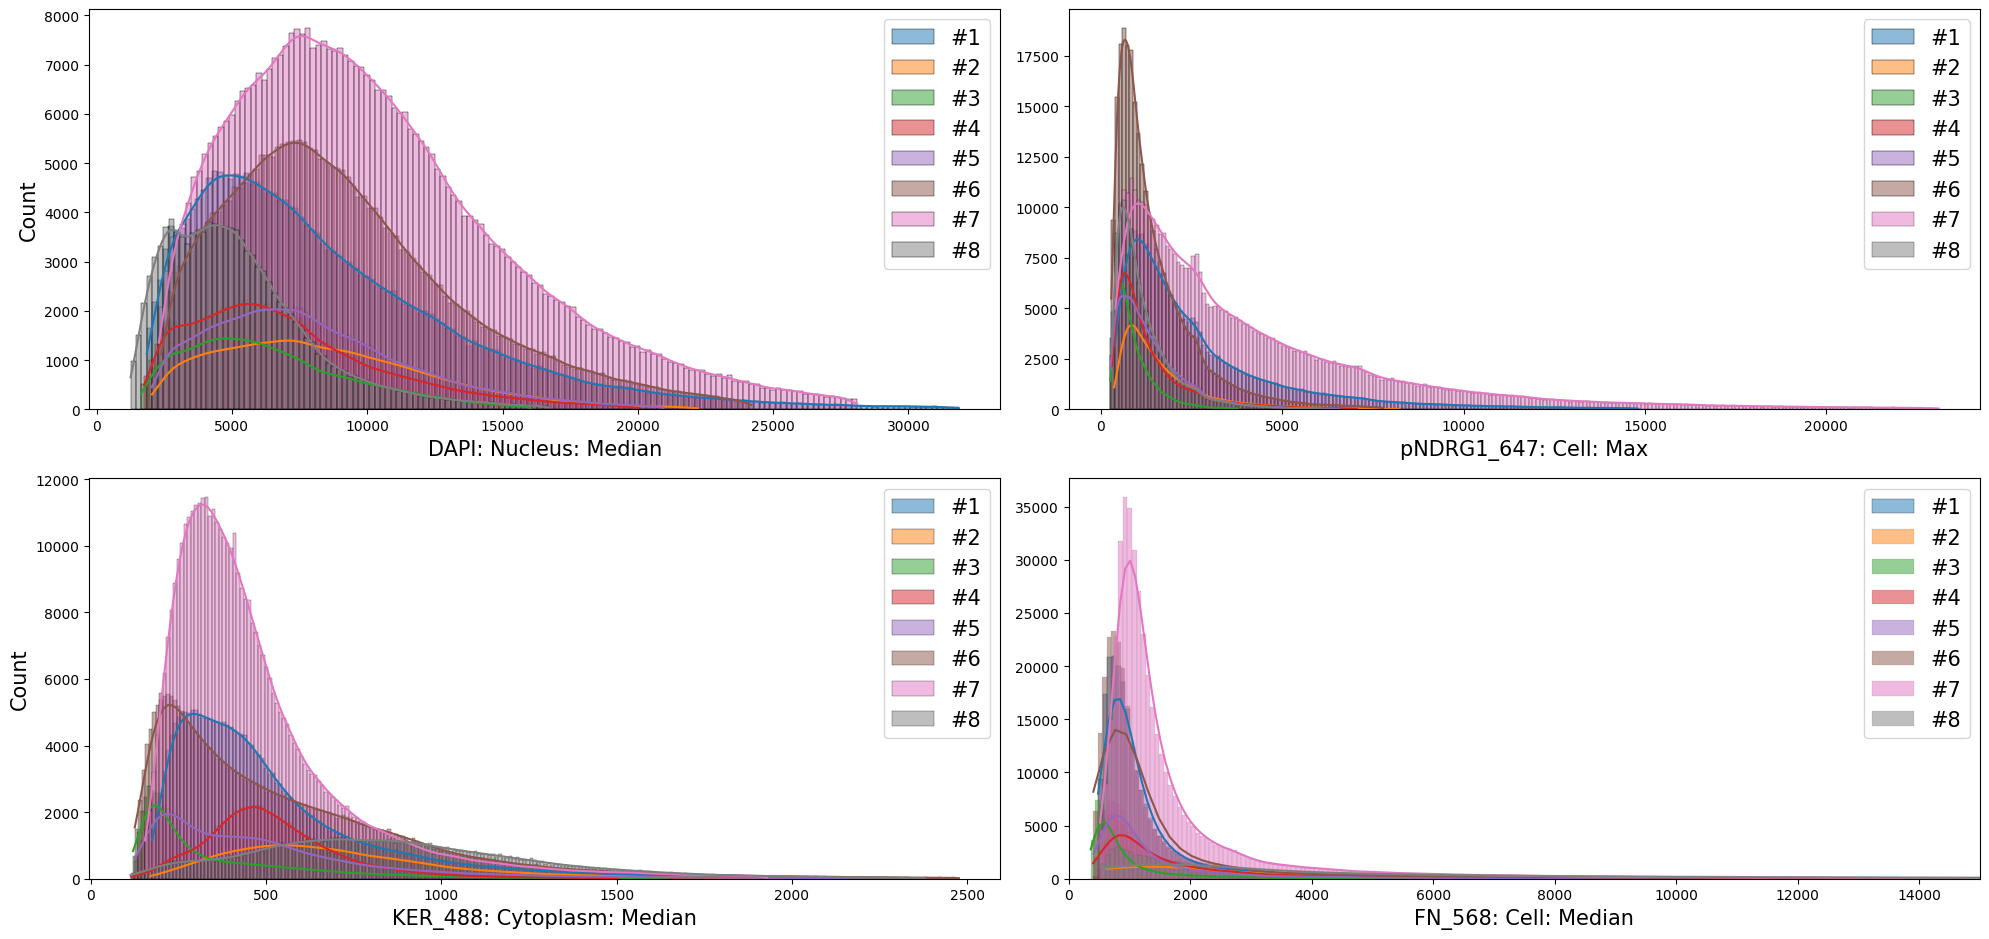

In [6]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

dfs = []

for idx, image in enumerate(csv_files):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(image)

    # Remove outliers using IQR for DAPI intensities
    p01_dapi = df['DAPI: Nucleus: Median'].quantile(0.01)
    p99_dapi = df['DAPI: Nucleus: Median'].quantile(0.99)
    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.01)
    p99_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['pNDRG1_647: Cell: Max'] >= p01_pNDRG1) & 
                       (df['pNDRG1_647: Cell: Max'] <= p99_pNDRG1) &
                       (df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) &
                       (df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) & 
                       (df['DAPI: Nucleus: Median'] >= p01_dapi) & 
                       (df['DAPI: Nucleus: Median'] <= p99_dapi)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['DAPI: Nucleus: Median'], binwidth=200, kde=True, ax=axs[0, 0], label=f'{gem_number}', alpha=0.5)
    # Plot yH2AX intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['pNDRG1_647: Cell: Max'], binwidth=100, kde=True, ax=axs[0, 1], label=f'{gem_number}', alpha=0.5)
    # Plot KER intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=10, kde=True, ax=axs[1, 0], label=f'{gem_number}', alpha=0.5)
    # Plot FN intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=75, kde=True, ax=axs[1, 1], label=f'{gem_number}', alpha=0.5)

    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

# Overlay distribution across all images (without outliers)
#sns.histplot(dfs_data['DAPI: Nucleus: Median'], binwidth=100,  kde=True, ax=axs[0, 0], color='black', label='All Images', alpha=0.2)
#sns.histplot(dfs_data['pNDRG1_647: Cell: MedianTotalIntensity'], binwidth=10000, kde=True, ax=axs[0, 1], color='black', label='All Images', alpha=0.2)
#sns.histplot(dfs_data['KER_488: Cytoplasm: MedianTotalIntensity'], binwidth=10000, kde=True, ax=axs[1, 0], color='black', label='All Images', alpha=0.2)
#sns.histplot(dfs_data['FN_568: Cell: Median'], binwidth=100, kde=True, ax=axs[1, 1], color='black', label='All Images', alpha=0.2)

# Set log scale
for ax_row in axs:
    for ax in ax_row:
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        ax.set_ylabel('')

axs[0, 0].legend(fontsize=15)
axs[0, 1].legend(fontsize=15)
axs[1, 0].legend(fontsize=15)
axs[1, 1].legend(fontsize=15)

axs[0, 0].set_ylabel('Count', fontsize=15)
axs[0, 1].set_ylabel('')
axs[1, 0].set_ylabel('Count', fontsize=15)
axs[1, 1].set_ylabel('')

axs[0, 0].set_xlabel('DAPI: Nucleus: Median', fontsize=15)
axs[0, 1].set_xlabel('pNDRG1_647: Cell: Max', fontsize=15)
axs[1, 0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=15)
axs[1, 1].set_xlabel('FN_568: Cell: Median', fontsize=15)
axs[1, 1].set_xlim([0, 15000])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_linear", dpi=300)
plt.show()


## Semi-logy distributions

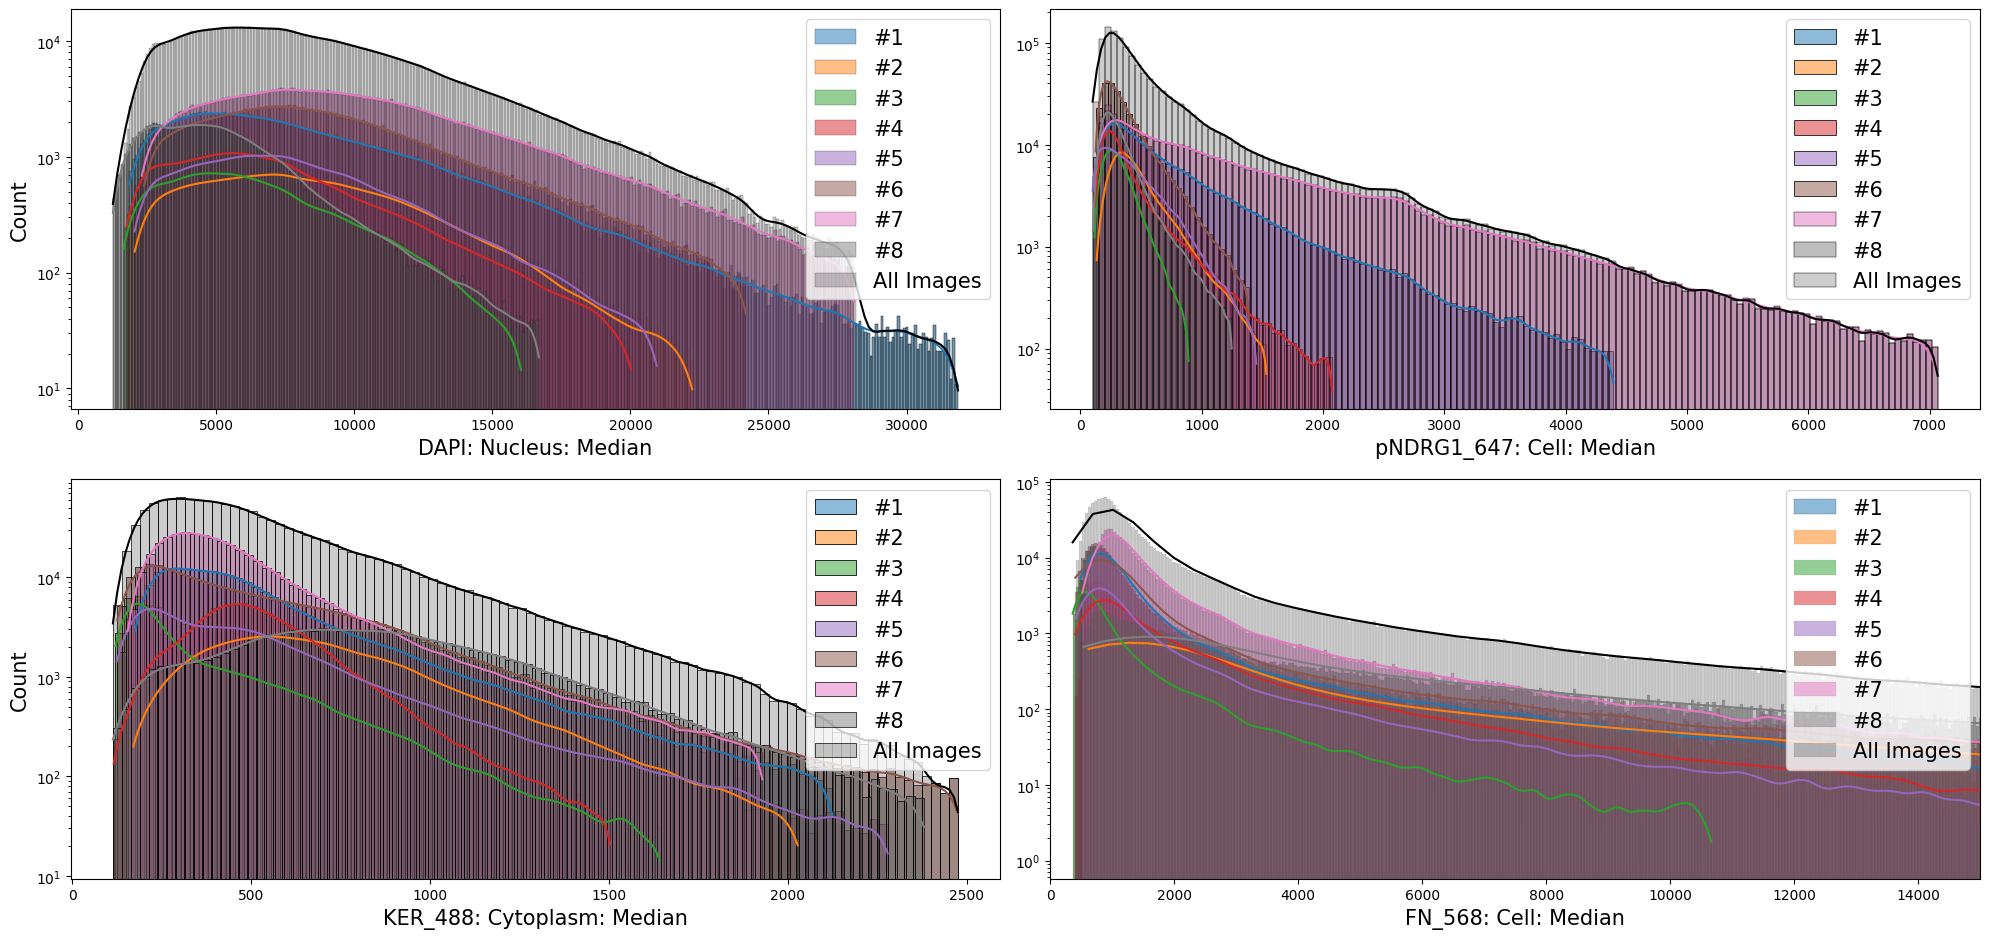

In [31]:
# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Median', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

dfs = []

for idx, image in enumerate(csv_files):

    file_path = f'AsPC LZ #{idx} GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv'
    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for DAPI intensities
    p01_dapi = df['DAPI: Nucleus: Median'].quantile(0.01)
    p99_dapi = df['DAPI: Nucleus: Median'].quantile(0.99)
    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['pNDRG1_647: Cell: Median'].quantile(0.01)
    p99_pNDRG1 = df['pNDRG1_647: Cell: Median'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['pNDRG1_647: Cell: Median'] >= p01_pNDRG1) & 
                       (df['pNDRG1_647: Cell: Median'] <= p99_pNDRG1) &
                       (df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) &
                       (df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) & 
                       (df['DAPI: Nucleus: Median'] >= p01_dapi) & 
                       (df['DAPI: Nucleus: Median'] <= p99_dapi)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['DAPI: Nucleus: Median'], binwidth=100, kde=True, ax=axs[0, 0], label=f'{gem_number}', alpha=0.5)
    # Plot yH2AX intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['pNDRG1_647: Cell: Median'], binwidth=50, kde=True, ax=axs[0, 1], label=f'{gem_number}', alpha=0.5)
    # Plot KER intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=25, kde=True, ax=axs[1, 0], label=f'{gem_number}', alpha=0.5)
    # Plot FN intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=True, ax=axs[1, 1], label=f'{gem_number}', alpha=0.5)

    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

# Overlay distribution across all images (without outliers)
sns.histplot(dfs_data['DAPI: Nucleus: Median'], binwidth=100,  kde=True, ax=axs[0, 0], color='black', label='All Images', alpha=0.2)
sns.histplot(dfs_data['pNDRG1_647: Cell: Median'], binwidth=50, kde=True, ax=axs[0, 1], color='black', label='All Images', alpha=0.2)
sns.histplot(dfs_data['KER_488: Cytoplasm: Median'], binwidth=25, kde=True, ax=axs[1, 0], color='black', label='All Images', alpha=0.2)
sns.histplot(dfs_data['FN_568: Cell: Median'], binwidth=50, kde=True, ax=axs[1, 1], color='black', label='All Images', alpha=0.2)

# Set log scale
for ax_row in axs:
    for ax in ax_row:
        ax.set_yscale('log')
        ax.set_ylabel('')

axs[0, 0].legend(fontsize=15)
axs[0, 1].legend(fontsize=15)
axs[1, 0].legend(fontsize=15)
axs[1, 1].legend(fontsize=15)

axs[0, 0].set_ylabel('Count', fontsize=15)
axs[0, 1].set_ylabel('')
axs[1, 0].set_ylabel('Count', fontsize=15)
axs[1, 1].set_ylabel('')

axs[0, 0].set_xlabel('DAPI: Nucleus: Median', fontsize=15)
axs[0, 1].set_xlabel('pNDRG1_647: Cell: Median', fontsize=15)
axs[1, 0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=15)
axs[1, 1].set_xlabel('FN_568: Cell: Median', fontsize=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
axs[1, 1].set_xlim([0, 15000])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_semilogy.png", dpi=300)
plt.show()


## Exploring non-gaussian distributions using the `Fitter` library

### pNDRG1_647 distributions

#### Finding the right distributions; result = lognormal (4 out of 8) + 3 inv gauss which is very similar

/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:00:41.267 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)


145


2024-06-13 15:00:41.525 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 15:00:42.038 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:00:44.340 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)


{'lognorm': {'s': 0.9281815286151913, 'loc': 247.15731887770025, 'scale': 1666.8238134911055}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:00:44.826 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-06-13 15:00:44.919 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


64


2024-06-13 15:00:45.286 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=2e-06)
2024-06-13 15:00:45.996 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)


{'lognorm': {'s': 0.7362730285131467, 'loc': 99.31802776156529, 'scale': 1005.1944933046018}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:00:47.195 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)


139


2024-06-13 15:00:47.453 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 15:00:49.125 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:00:50.866 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)


{'invgauss': {'mu': 0.8237927665415783, 'loc': 130.4160615147116, 'scale': 1693.516658790822}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
366


2024-06-13 15:00:53.036 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-06-13 15:00:53.171 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 15:00:53.858 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:00:58.363 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)


{'expon': {'loc': 390.0, 'scale': 3875.654466782801}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:00:58.909 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 15:00:59.034 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


424


2024-06-13 15:00:59.588 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:01:00.394 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)


{'invgauss': {'mu': 0.7341808826392737, 'loc': 159.04658390717793, 'scale': 1468.5494451521627}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:01:00.885 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-06-13 15:01:00.965 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


503


2024-06-13 15:01:01.369 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:01:01.842 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)


{'invgauss': {'mu': 0.705043629484224, 'loc': 175.14542081425566, 'scale': 2205.041025138832}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:01:02.156 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=3e-06)
2024-06-13 15:01:02.216 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


538


2024-06-13 15:01:02.490 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:01:02.855 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=3e-06)


{'lognorm': {'s': 0.7176275236903199, 'loc': 181.85559216791043, 'scale': 588.0417034680396}}
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10/SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:01:03.353 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 15:01:03.444 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


605


2024-06-13 15:01:03.630 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 15:01:04.496 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2e-06)


{'lognorm': {'s': 0.9131055542414832, 'loc': 251.84516347846628, 'scale': 798.9757148769207}}


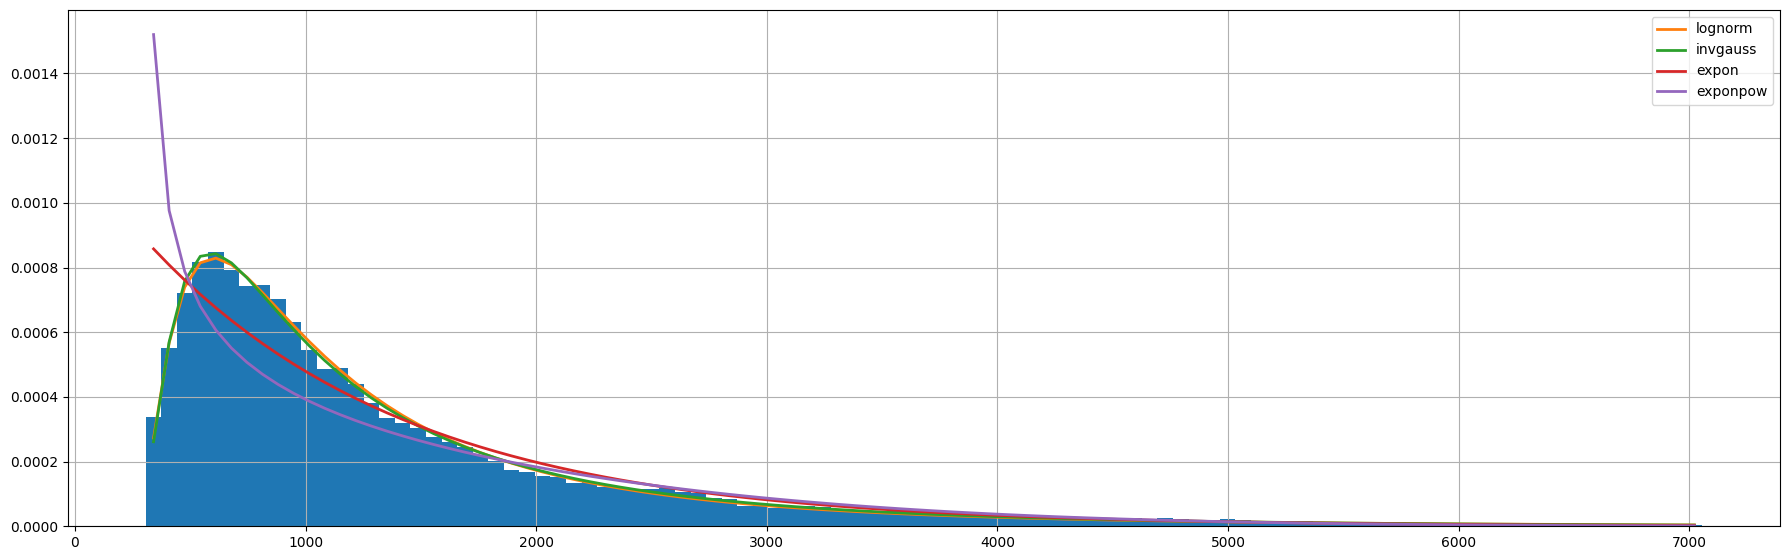

In [9]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10"

# Get a list of all CSV files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
file_paths = natsort.natsorted(file_paths)

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(1, 4, figsize=(18, 6))

dfs = []
params_reference = None
threshold_reference = 0

for idx, image in enumerate(file_paths):

    print(image)
    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.01)
    p99_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.99)
    
    df_no_outlier = df[(df['pNDRG1_647: Cell: Max'] >= p01_pNDRG1) & 
                       (df['pNDRG1_647: Cell: Max'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['pNDRG1_647: Cell: Max'], binwidth=100, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5)

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['pNDRG1_647: Cell: Max'],
               distributions= ["invgauss", "lognorm", "expon", "exponpow"]
               )
    f.fit()
    summary = f.summary(clf=True)
    print(f.get_best(method = 'sumsquare_error'))
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('pNDRG1_647: Cell: Max', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_linear.png", dpi=300)
plt.show()

SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:04:59.725 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.9131055542414832, 'loc': 251.84516347846628, 'scale': 798.9757148769207}
SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:01.064 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.9281815286151913, 'loc': 247.15731887770025, 'scale': 1666.8238134911055}
Translated threshold for img1: 2870.31
Scaled threshold for img1: 2851.06
SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:01.719 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.7362730285131467, 'loc': 99.31802776156529, 'scale': 1005.1944933046018}
Translated threshold for img2: 1539.66
Scaled threshold for img2: 1669.63
SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:03.233 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.8660906016817408, 'loc': 202.0086618309407, 'scale': 928.5450004747438}
Translated threshold for img3: 1619.64
Scaled threshold for img3: 1652.58
SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:05.421 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.9931179130631824, 'loc': 172.33162159806096, 'scale': 2637.4177911739466}
Translated threshold for img4: 4456.73
Scaled threshold for img4: 4292.49
SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:06.262 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.8199860607031537, 'loc': 212.98209740883414, 'scale': 741.767834951213}
Translated threshold for img5: 1320.23
Scaled threshold for img5: 1371.77
SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:06.752 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.805473702991208, 'loc': 252.40864628436665, 'scale': 1081.8287189386415}
Translated threshold for img6: 1855.86
Scaled threshold for img6: 1942.43
SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:05:07.129 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/1939356811.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.7176275236903199, 'loc': 181.85559216791043, 'scale': 588.0417034680396}
Translated threshold for img7: 1016.82
Scaled threshold for img7: 1100.49


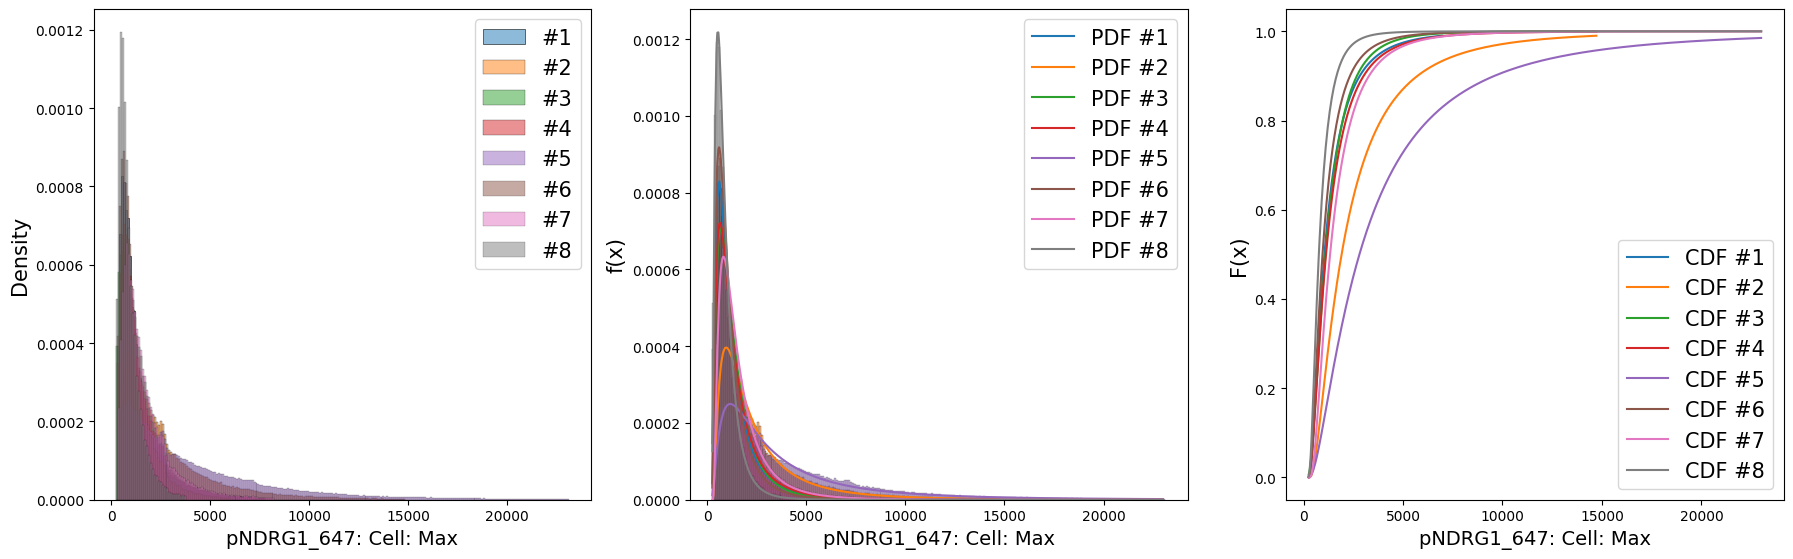

In [12]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10"

file_paths = ["SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
              ]

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

dfs = []
params_reference = None
threshold_reference = 1500

for idx, image in enumerate(file_paths):

    print(image)
    gem_number = f"#{idx + 1}"
    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.01)
    p99_pNDRG1 = df['pNDRG1_647: Cell: Max'].quantile(0.99)

    
    df_no_outlier = df[(df['pNDRG1_647: Cell: Max'] >= p01_pNDRG1) & 
                       (df['pNDRG1_647: Cell: Max'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    hist_plot = sns.histplot(df_no_outlier['pNDRG1_647: Cell: Max'], binwidth=100, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5, stat='density')

    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins = np.sort(bins)
    
    f = Fitter(df_no_outlier['pNDRG1_647: Cell: Max'],
               distributions=['lognorm']
               )
    
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('lognorm')
    print(params)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = lognorm.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = lognorm.cdf(bins, **params)
    pdf_values = lognorm.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['pNDRG1_647: Cell: Max'], binwidth=100, kde=False, ax=axs[1], alpha=0.5, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f'CDF {gem_number}')
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('pNDRG1_647: Cell: Max', fontsize=14)

axs[1].legend(fontsize=15)
axs[1].set_ylabel(r'f(x)', fontsize=15)
axs[1].set_xlabel('pNDRG1_647: Cell: Max', fontsize=14)

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('pNDRG1_647: Cell: Max', fontsize=14)

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_pNDRG1_SW1990_lognormal.png", dpi=300)
plt.show()

### KER_488 distributions

#### Finding the right distribution; result: lognorm (4 out of 8)

SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:07:17.332 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=2e-06)


140
{'s': 0.3010898308111712, 'loc': -133.82066575323992, 'scale': 629.2777393961259}
SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


335


2024-06-13 15:07:18.880 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.7647183026743903, 'loc': 141.95141690366478, 'scale': 291.471019369331}
Translated threshold for img1: 224.99
Scaled threshold for img1: 319.73
SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:07:19.528 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=2e-06)


550
{'s': 0.8251515477607098, 'loc': 92.15934817489082, 'scale': 302.8478591375037}
Translated threshold for img2: 170.28
Scaled threshold for img2: 276.88
SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-06-13 15:07:20.924 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)


785
{'s': 0.844009196824546, 'loc': 88.68438848535254, 'scale': 338.52324630665595}
Translated threshold for img3: 173.35
Scaled threshold for img3: 295.16


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
962


2024-06-13 15:07:23.524 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'s': 0.6816476978603024, 'loc': 119.71090324383094, 'scale': 289.7146495992643}
Translated threshold for img4: 214.31
Scaled threshold for img4: 296.42
SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:07:24.441 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1189
{'s': 0.2799709694083863, 'loc': -592.7269978369042, 'scale': 1399.2558698163607}
Translated threshold for img5: 290.85
Scaled threshold for img5: 260.73


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


2024-06-13 15:07:25.030 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1375
{'s': 0.42092193295726615, 'loc': -48.92275530688533, 'scale': 688.1611315891399}
Translated threshold for img6: 295.84
Scaled threshold for img6: 370.81
SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-06-13 15:07:25.451 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=4e-06)


1527
{'s': 1.076293239005368, 'loc': 116.63543957675272, 'scale': 150.22460757280933}
Translated threshold for img7: 142.29
Scaled threshold for img7: 208.26


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_42859/2251246089.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


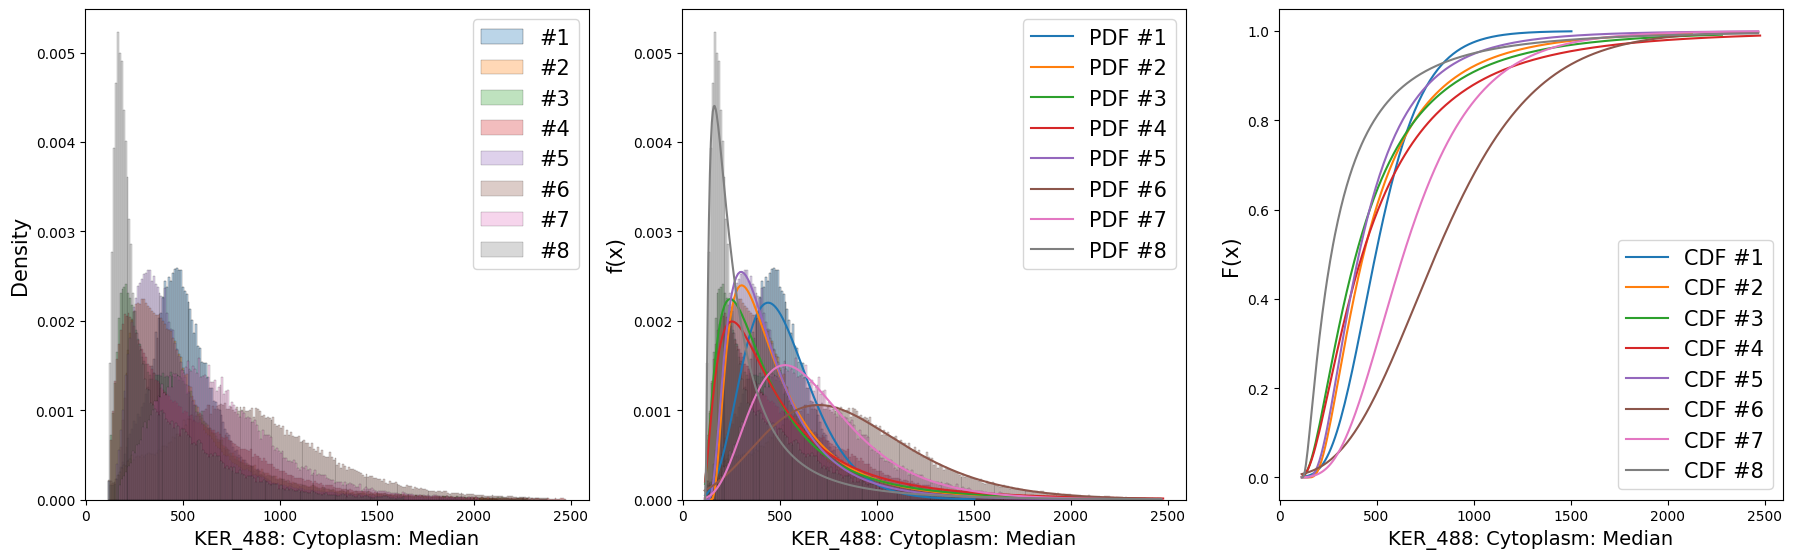

In [13]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240320_sigma10"

file_paths = ["SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv", 
              "SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv"
              ]

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']


fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[2].clear()
dfs = []
params_reference = None
threshold_reference = 250

for idx, image in enumerate(file_paths):

    print(image)
    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)

    
    df_no_outlier = df[(df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) 
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=10, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.3, stat='density')

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['KER_488: Cytoplasm: Median'],
               distributions=['lognorm']
               )
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('lognorm')
    print(params)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = lognorm.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = lognorm.cdf(bins, **params)
    pdf_values = lognorm.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=10, kde=False, ax=axs[1], alpha=0.3, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f"CDF {gem_number}")
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[1].legend(fontsize=15)
axs[1].set_ylabel('f(x)', fontsize=15)
axs[1].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_KER_SW1990_lognormal.png", dpi=300)
plt.show()

### FN_648

#### Finding the right distribution; result: lognorm (4 out of 5)

2024-03-15 10:28:51.355 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3e-06)
2024-03-15 10:28:51.405 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)


361


2024-03-15 10:28:51.546 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)
2024-03-15 10:28:51.606 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:28:52.111 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:28:53.519 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:28:54.233 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=4e-06)
2024-03-15 10:28:54.312 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:28:56.608 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-03-15 10:28:56.621 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with e

{'burr': {'c': 2.2662669285629367, 'd': 418.82190448133883, 'loc': -1.2110134304947775, 'scale': 61.321733891705264}}


2024-03-15 10:29:05.008 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-03-15 10:29:05.015 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-03-15 10:29:05.112 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-03-15 10:29:05.167 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1295


2024-03-15 10:29:05.512 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:29:06.242 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:06.611 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-03-15 10:29:06.696 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-03-15 10:29:07.130 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-03-15 10:29:07.135 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-03-15 10:29:09.169 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'lognorm': {'s': 1.5598155915963179, 'loc': 615.6649495591611, 'scale': 1491.1634877629435}}


2024-03-15 10:29:09.617 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-03-15 10:29:09.623 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=6e-06)
2024-03-15 10:29:09.712 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=5e-06)
2024-03-15 10:29:09.782 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1501


2024-03-15 10:29:10.003 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=1e-06)
2024-03-15 10:29:10.725 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:11.030 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=9e-06)
2024-03-15 10:29:11.143 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:29:11.451 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2e-06)
2024-03-15 10:29:11.471 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-03-15 10:29:13.106 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'invgauss': {'mu': 2.0294376252009343, 'loc': 333.25779886622234, 'scale': 380.251672848815}}


2024-03-15 10:29:13.781 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-03-15 10:29:13.810 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-03-15 10:29:13.857 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


1847


2024-03-15 10:29:13.960 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:29:14.179 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:29:14.780 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:15.300 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=1e-06)
2024-03-15 10:29:15.421 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:29:15.983 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-03-15 10:29:16.047 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-03-15 10:29:18.524 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error

{'invgauss': {'mu': 1.6877155604484209, 'loc': 362.954520703796, 'scale': 1041.4045270395331}}


2024-03-15 10:29:19.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-03-15 10:29:19.189 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2e-06)
2024-03-15 10:29:19.284 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)


2150


2024-03-15 10:29:19.365 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:29:19.625 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:29:20.329 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:20.750 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=4e-06)
2024-03-15 10:29:21.016 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:29:21.497 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-03-15 10:29:21.524 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-03-15 10:29:24.346 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error

{'burr': {'c': 2.010390314779973, 'd': 584.6546224833152, 'loc': -1.8518636631370944, 'scale': 37.19958243936862}}


2024-03-15 10:29:25.713 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-03-15 10:29:25.727 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)


2866


2024-03-15 10:29:25.875 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)
2024-03-15 10:29:25.936 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:29:26.427 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:29:27.643 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:28.675 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=2e-06)
2024-03-15 10:29:29.344 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:29:31.436 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-03-15 10:29:31.484 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with err

{'burr': {'c': 1.8612413110197288, 'd': 535.0332418102016, 'loc': -1.5917887735437057, 'scale': 29.840145459348676}}


2024-03-15 10:29:42.185 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2e-06)
2024-03-15 10:29:42.199 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)


3195


2024-03-15 10:29:42.413 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)
2024-03-15 10:29:42.449 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:29:43.083 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:29:45.219 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:29:46.738 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=3e-06)
2024-03-15 10:29:47.828 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-03-15 10:29:48.303 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-03-15 10:29:50.621 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with e

{'burr': {'c': 2.258425862877966, 'd': 830.2829593565239, 'loc': -2.067689758120617, 'scale': 56.505253273557265}}


2024-03-15 10:30:04.040 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-03-15 10:30:04.054 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)


4491


2024-03-15 10:30:04.264 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-15 10:30:04.274 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-03-15 10:30:04.651 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-15 10:30:05.351 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-03-15 10:30:05.913 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-03-15 10:30:06.005 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-03-15 10:30:06.701 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-03-15 10:30:06.720 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0

{'lognorm': {'s': 1.5042229156732745, 'loc': 517.8708671137412, 'scale': 2637.4509149705177}}


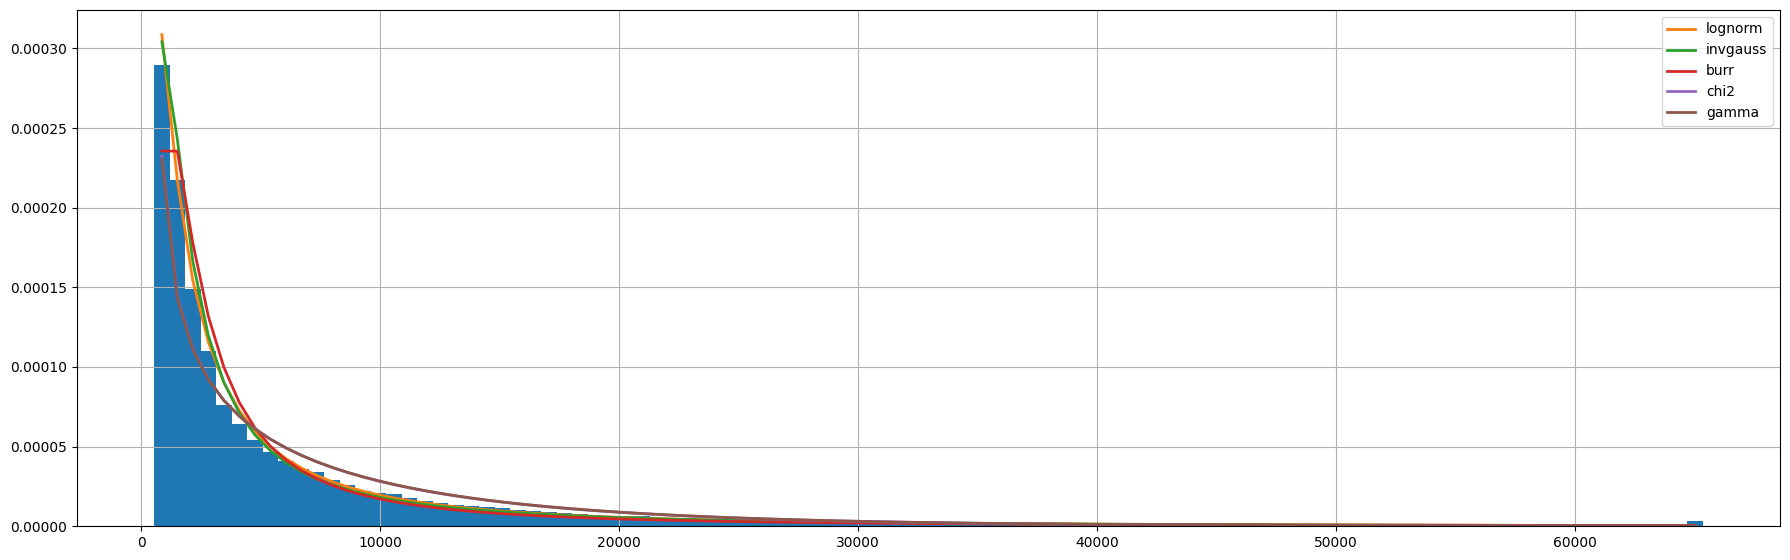

In [26]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/exploratory/20240315_all_cells_data"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: MedianTotalIntensity', 
                   'pNDRG1_647: Cell: MedianTotalIntensity', 
                   'FN_568: Cell: MedianTotalIntensity', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

def fit_function(k, lamb):
    # The parameter lamb will be used as the fit parameter
    return poisson.pmf(k, lamb)

fig, axs = plt.subplots(1, 4, figsize=(18, 6))

dfs = []
params_reference = None
threshold_reference = 150000

for idx, image in enumerate(csv_files):

    file_path = f'AsPC LZ #{idx} GEM  Ker488 FN 568 pN 647 _01.vsi - 20x.csv'
    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) 
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5)

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['FN_568: Cell: Median'],
               distributions= ["gamma", "invgauss", "lognorm", "beta", "burr", "norm", "expon", "rayleigh", "cauchy", "chi2", "exponpow"]
               )
    f.fit()
    summary = f.summary(clf=True)
    print(f.get_best(method = 'sumsquare_error'))
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('FN_568: Cell: Median', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_pNDRG1/Results/20240222_plots/exploratory/20240301_distributions_allchannels_allcells_linear", dpi=300)
plt.show()

['SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv', 'SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv']


2024-03-21 13:54:32.922 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


347
{'lognorm': {'s': 1.051032661213995, 'loc': 395.00626947562574, 'scale': 956.2267399699982}}
SW shC Dox GEM  #15.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:33.825 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


553
{'lognorm': {'s': 1.1444298574478202, 'loc': 354.3717318655399, 'scale': 374.9112596389268}}
SW shC Dox GEM  #14.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img1: 1706.08
Scaled threshold for img1: 1571.76


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:34.628 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1847
{'lognorm': {'s': 1.5598155915963179, 'loc': 615.6649495591611, 'scale': 1491.1634877629435}}
SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img2: 9178.77
Scaled threshold for img2: 5457.67


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:36.018 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


3143
{'lognorm': {'s': 1.5042229156732745, 'loc': 517.8708671137412, 'scale': 2637.4509149705177}}
SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img3: 14748.88
Scaled threshold for img3: 9082.02


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:38.953 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


3472


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'lognorm': {'s': 0.9754795844939178, 'loc': 499.87972621783257, 'scale': 818.4103760904434}}
SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img4: 2941.63
Scaled threshold for img4: 3157.37


2024-03-21 13:54:41.451 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


4188
{'lognorm': {'s': 1.2471724733628426, 'loc': 398.6426352131891, 'scale': 663.6021649575146}}
SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img5: 3083.13
Scaled threshold for img5: 2553.45


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:42.478 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


4491
{'lognorm': {'s': 1.081238791801971, 'loc': 396.2124133928603, 'scale': 665.9095489997634}}
SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img6: 2632.95
Scaled threshold for img6: 2558.51


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-03-21 13:54:44.014 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


4851
{'lognorm': {'s': 1.1600702005690318, 'loc': 474.3950630852557, 'scale': 534.6109223829961}}
SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
Translated threshold for img7: 2435.96
Scaled threshold for img7: 2210.35


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_77434/2237058150.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


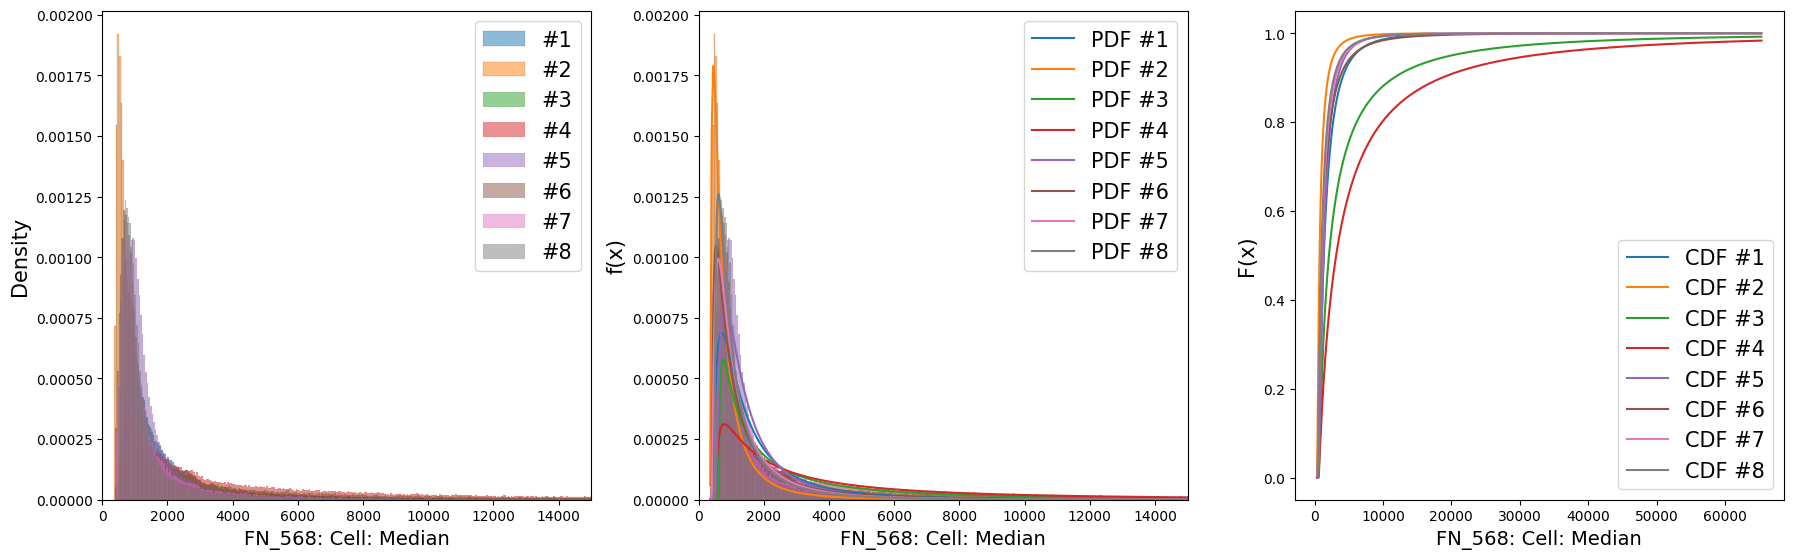

In [30]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/exploratory/20240315_all_cells_data"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = natsort.natsorted(csv_files)
csv_files = csv_files[::-1]
print(csv_files)
# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'FN_568: Cell: Median', 
                   'KER_488: Cytoplasm: MedianTotalIntensity', 
                   'pNDRG1_647: Cell: MedianTotalIntensity', 
                   'FN_568: Cell: MedianTotalIntensity', 
                   'Nucleus: Area µm^2']

def fit_function(k, lamb):
    # The parameter lamb will be used as the fit parameter
    return poisson.pmf(k, lamb)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

dfs = []
params_reference = None
threshold_reference = 3500

for idx, image in enumerate(csv_files):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['FN_568: Cell: Median'].quantile(0.01)
    p99_pNDRG1 = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['FN_568: Cell: Median'] >= p01_pNDRG1) & 
                       (df['FN_568: Cell: Median'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5, stat='density')

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['FN_568: Cell: Median'],
               distributions=['lognorm']
               )
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('lognorm')
    print(f.get_best(method = 'sumsquare_error'))
    print(image)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = lognorm.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = lognorm.cdf(bins, **params)
    pdf_values = lognorm.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[1], alpha=0.5, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f'CDF {gem_number}')
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('FN_568: Cell: Median', fontsize=14)
axs[0].set_xlim([0, 15000])

axs[1].legend(fontsize=15)
axs[1].set_ylabel(r'f(x)', fontsize=15)
axs[1].set_xlabel('FN_568: Cell: Median', fontsize=14)
axs[1].set_xlim([0, 15000])

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('FN_568: Cell: Median', fontsize=14)
#axs[2].set_xlim([0, 15000])

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_FN647_SW1990_median_lognormal.png", dpi=300)
plt.show()